In [1]:
import os
from datetime import datetime

import numpy as np
import cv2
import PIL

import keras
from keras.models import Sequential, Model, load_model, model_from_json
from keras.layers import Dense, Flatten, Dropout, Activation, LeakyReLU, Reshape, Concatenate, Input
from keras.layers import Conv2D, UpSampling2D, Conv2DTranspose, MaxPool2D, AtrousConv2D
from keras.layers.normalization import BatchNormalization
from keras import optimizers, losses
import keras.backend as K

from keras_contrib.layers.normalization import InstanceNormalization

from IPython.display import display, Image

Using TensorFlow backend.


In [2]:
import DataLoader

In [3]:
# Initialize DataLoader
data = DataLoader.Data()

In [4]:
data.get_data(300).shape

(300, 256, 256, 3)

In [51]:
# Saves model in every N minutes
TIME_INTERVAL = 1
SHOW_SUMMARY = True

INPUT_SHAPE =  (256, 256, 3)
EPOCHS = 500
BATCH_SIZE = 1

# 25% i.e 64 width size will be mask from both side          #??
MASK_PERCENT = 0.25

CHECKPOINT = 'model/'
SAVED_IMGS = 'saved_images/'

## MODELS

### Discriminator

In [52]:
d_input_shape = (INPUT_SHAPE[0], int(INPUT_SHAPE[1] * (MASK_PERCENT * 2)), INPUT_SHAPE[2])
d_dropout = 0.25
DCRM_OPTIMIZER = optimizers.Adam(lr = 0.0001, beta_1 = 0.5, beta_2 = 0.999)

In [53]:
def d_build_conv(layer_input, filters, kernel_size = 4, strides = 2, padding = 'same', activation = 'leakyrelu', dropout_rate = d_dropout, norm = True):
    conv = Conv2D(filters, kernel_size = kernel_size, strides = strides, padding = padding)(layer_input)
    
    if activation == 'leakyrelu':
        conv = LeakyReLU(alpha = 0.2)(conv)
    
    if dropout_rate:
        conv = Dropout(rate = dropout_rate)(conv)
        
    if norm:
        conv = InstanceNormalization()(conv)
        
    return conv

In [54]:
def build_discriminator():
    d_input = Input(shape = d_input_shape)
    d = d_build_conv(d_input, 32, 5, norm = False)
    filters = 64
    for i in range(4):
        d = d_build_conv(d, filters, 5)
    flat = Flatten()(d)
    fc1 = Dense(512, activation = 'relu')(flat)
    d_output = Dense(1, activation = 'sigmoid')(fc1)
    
    return Model(inputs = d_input, outputs = d_output)

In [55]:
# Discriminator initialization
DCRM = build_discriminator()
DCRM.trainable = False          #?? why
DCRM.compile(loss = losses.MSE, optimizer = DCRM_OPTIMIZER)
if SHOW_SUMMARY:
    DCRM.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         (None, 256, 128, 3)       0         
_________________________________________________________________
conv2d_33 (Conv2D)           (None, 128, 64, 32)       2432      
_________________________________________________________________
leaky_re_lu_11 (LeakyReLU)   (None, 128, 64, 32)       0         
_________________________________________________________________
dropout_31 (Dropout)         (None, 128, 64, 32)       0         
_________________________________________________________________
conv2d_34 (Conv2D)           (None, 64, 32, 64)        51264     
_________________________________________________________________
leaky_re_lu_12 (LeakyReLU)   (None, 64, 32, 64)        0         
_________________________________________________________________
dropout_32 (Dropout)         (None, 64, 32, 64)        0         
__________

### Generator

In [56]:
g_input_shape = (INPUT_SHAPE[0], int(INPUT_SHAPE[1] * (MASK_PERCENT * 2)), INPUT_SHAPE[2])
g_dropout = 0.25
GEN_OPTIMIZER = optimizers.Adam(lr = 0.001, beta_1 = 0.5, beta_2 = 0.999)

In [57]:
def g_build_conv(layer_input, filters, kernel_size = 4, strides = 2, padding = 'same', activation = 'relu', dropout_prob = g_dropout, norm = True, dilation_rate = 1):
    conv = Conv2D(filters, kernel_size = kernel_size, strides = strides, dilation_rate = (dilation_rate, dilation_rate), padding = padding)(layer_input)
    
    if dropout_prob:
        conv = Dropout(rate = dropout_prob)(conv)
    
    if activation == 'relu':
        conv = Activation('relu')(conv)
        
    if norm:
        conv = InstanceNormalization()(conv)
        
    return conv

In [58]:
def g_build_deconv(layer_input, filters, kernel_size = 3, strides = 2, activation = 'relu'):
    deconv = Conv2DTranspose(filters, kernel_size = kernel_size, strides = strides, padding = 'same')(layer_input)
    if activation == 'relu':
        deconv = Activation('relu')(deconv)
    return deconv

In [59]:
def build_generator():
    g_input = Input(shape = g_input_shape)
    
    g1 = g_build_conv(g_input, 64, 5, strides = 1)
    g2 = g_build_conv(g1, 128, 4, strides = 2)
    g3 = g_build_conv(g2, 128, 4, strides = 2)

    g4 = g_build_conv(g3, 256, 4, strides = 1)
    g5 = g_build_conv(g4, 512, 3, strides = 1, dilation_rate = 2)
    g6 = g_build_conv(g5, 512, 3, strides = 1, dilation_rate = 4)
    g7 = g_build_conv(g6, 512, 3, strides = 1, dilation_rate = 8)
    g8 = g_build_conv(g7, 512, 3, strides = 1, dilation_rate = 16)
    
    g9 = g_build_conv(g8, 256, 4, strides = 1)
    g10 = g_build_deconv(g9, 128, 4, strides = 2)
    g11 = g_build_deconv(g10, 128, 4, strides = 2)
    g12 = g_build_conv(g11, 64, 4, strides = 1)
    
    g_output = Conv2D(3, kernel_size = 4, strides = (1,1), activation = 'tanh', padding = 'same', dilation_rate = (1,1))(g11)
    
    return Model(g_input, g_output)

In [60]:
# Generator Initialization
GEN = build_generator()
GEN.compile(loss='mse', optimizer=GEN_OPTIMIZER)
if SHOW_SUMMARY:
    GEN.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         (None, 256, 128, 3)       0         
_________________________________________________________________
conv2d_38 (Conv2D)           (None, 256, 128, 64)      4864      
_________________________________________________________________
dropout_36 (Dropout)         (None, 256, 128, 64)      0         
_________________________________________________________________
activation_25 (Activation)   (None, 256, 128, 64)      0         
_________________________________________________________________
instance_normalization_33 (I (None, 256, 128, 64)      2         
_________________________________________________________________
conv2d_39 (Conv2D)           (None, 128, 64, 128)      131200    
_________________________________________________________________
dropout_37 (Dropout)         (None, 128, 64, 128)      0         
__________

### Combined Model

In [61]:
IMAGE = Input(shape = g_input_shape)
GENERATED_IMAGE = GEN(IMAGE)    #?? what conf stands for
CONF_GENERATED_IMAGE = DCRM(GENERATED_IMAGE)

COMBINED = Model(IMAGE, [CONF_GENERATED_IMAGE, GENERATED_IMAGE])
COMBINED.compile(loss = [losses.MSE, losses.MSE], optimizer = GEN_OPTIMIZER)

In [62]:
COMBINED.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         (None, 256, 128, 3)       0         
_________________________________________________________________
model_8 (Model)              (None, 256, 128, 3)       12072725  
_________________________________________________________________
model_7 (Model)              (None, 1)                 1410697   
Total params: 13,483,422
Trainable params: 12,072,725
Non-trainable params: 1,410,697
_________________________________________________________________


## Masking and De-Masking

In [63]:
from copy import deepcopy

In [64]:
def mask_width(img):
    img_copy = deepcopy(img)
    height = img_copy.shape[0]
    width = img_copy.shape[1]
    
    new_width = int(width * MASK_PERCENT)
    
    missing_left = img_copy[:, :new_width]
    missing_right = img_copy[:, width - new_width:]
    missing = np.concatenate((missing_left, missing_right), axis = 1)
    
#     print(missing.shape)
    
    img_copy = img_copy[:, new_width : width - new_width]
    
    return img_copy, missing

def get_masked_images(imgs):
    masked_imgs = []
    missing_imgs = []
    for img in imgs:
        masked_img, missing_img = mask_width(img)
        masked_imgs.append(masked_img)
        missing_imgs.append(missing_img)
    return np.asarray(masked_imgs), np.asarray(missing_imgs)

def get_demask_images(original_imgs, generated_imgs):
    demask_imgs = []
    for o_img, gen_img in zip(original_imgs, generated_imgs):           # gen_img is both the left and right missing part
        width = gen_img.shape[1] // 2                
        x_img = gen_img[:, :width]
        y_img = gen_img[:, width:]
        o_img = np.concatenate((x_img, o_img, y_img), axis = 1)
        demask_imgs.append(o_img)
    return np.asarray(demask_imgs)

After masking
	Original Image			 a 		 b


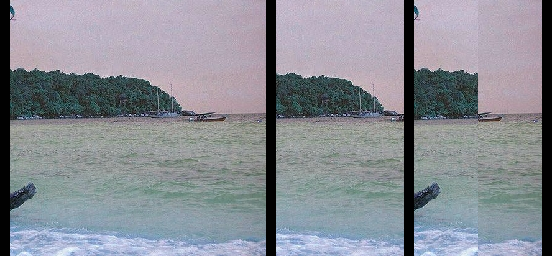

After desmasking: 'b/2' + a + 'b/2' 


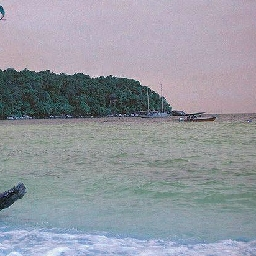

In [65]:
# Masking demasking example
x = data.get_data(1)

# NOTE : `a` will be the input and `b` will be the output of the model
a, b = get_masked_images(x)
border = np.ones([x[0].shape[0], 10, 3]).astype(np.uint8)
print('After masking')
print('\tOriginal Image\t\t\t a \t\t b')
image = np.concatenate((border, x[0], border, a[0], border, b[0], border), axis=1)
display(PIL.Image.fromarray(image))

print("After desmasking: 'b/2' + a + 'b/2' ")
c = get_demask_images(a,b)
display(PIL.Image.fromarray(c[0]))

## Utility functions
1. Save model
2. Load model
3. Save img
4. Save log

In [66]:
import json

In [67]:
def save_model():
    models = [DCRM, GEN]
    model_names = ['DCRM', 'GEN']
    for model, model_name in zip(models, model_names):
        wt_path = CHECKPOINT + '%s.h5'%(model_name)
        model.save_weights(wt_path)
        json.dump(model.to_json(), CHECKPOINT + '%s.json'%(model_name))
    
    print('SAVED MODEL')
        
def load():
    # Checking if all the model exists
    model_names = ['DCRM', 'GEN']
    files = os.listdir(CHECKPOINT)
    for model_name in model_names:
        if model_name+".json" not in files or model_name+".hdf5" not in files:
            print("Models not Found")
            return
        
    global DCRM_OPTIMIZER, GEN_OPTIMIZER, g_input_shape
    
    # loading DISCRIMINATOR
    DCRM = model_from_json(json.load(CHECKPOINT + 'DCRM.json'))
    DCRM.load_weights(CHECKPOINT + 'DCRM.h5')
    DCRM.compile(loss = losses.MSE, optimizer = DCRM_OPTIMIZER)
    
    # loading GENERATOR
    GEN = model_from_json(json.load(CHECKPOINT + 'GEN.json'))
    GEN.load_weights(CHECKPOINT + 'GEN.h5')
    GEN.compile(loss = losses.MSE, optimizer = GEN_OPTIMIZER)
    
    IMAGE = Input(shape = g_input_shape)
    DCRM.trainable = False
    GEN_IMAGE = GEN(IMAGE)
    CONF_GEN_IMAGE = DCRM(GEN_IMAGE)
    
    COMBINED = Model(inputs = IMAGE, outputs = [CONF_GENERATED_IMAGE, GEN_IMAGE])
    COMBINED.compile(loss = [losses.MSE, losses.MSE], optimizer = GEN_OPTIMIZER)
    
    print("loaded model")
    
def save_image(epoch, steps):
    original = data.get_data(1)
    masked_img, missing_img = get_masked_images(original)
    masked_img = masked_img / 127.5 - 1
    missing_img = missing_img / 127.5 - 1
    gen_missing = GEN(masked_img)
    gen_missing = (gen_missing + 1) * 127.5
    gen_missing = gen_missing.astype(np.unit8)
    
    demask_img = get_demask_images(masked_img, gen_missing)
    
    mask_image = (mask_image + 1) * 127.5
    mask_image = mask_image.astype(np.uint8)

    border = np.ones([original[0].shape[0], 10, 3]).astype(np.uint8)
    
    file_name = str(epoch) + "_" + str(steps) + ".jpg"
    final_image = np.concatenate((border, original[0], border, mask_image_original[0], border, demask_image[0], border), axis=1)
    cv2.imwrite(os.path.join(SAVED_IMAGES, file_name), final_image)
    print("\t1.Original image \t 2.Input \t\t 3. Output")
    display(PIL.Image.fromarray(final_image))
    print("image saved")

def save_log(log):
    with open('log.txt', 'a') as f:
        f.write("%s\n"%log)

In [71]:
def train():
    start_time = datetime.now()
    saved_time = start_time
    
    for epoch in range(1, EPOCHS):
        steps = 1
        test = None
        while True:
            original = data.get_data(BATCH_SIZE)
            if original is None:
                break
            batch_size = original.shape[0]

            mask_image, missing_image = get_masked_images(original)
            mask_image = mask_image / 127.5 - 1
            missing_image = missing_image / 127.5 - 1
            
            # Train Discriminator
            gen_missing = GEN.predict(mask_image)

            real = np.ones([batch_size, 1])
            fake = np.zeros([batch_size, 1])
            
            d_loss_original = DCRM.train_on_batch(missing_image, real)
            d_loss_mask = DCRM.train_on_batch(gen_missing, fake)
            d_loss = 0.5 * np.add(d_loss_original, d_loss_mask)

            # Train Generator
            for i in range(2):
                g_loss = COMBINED.train_on_batch(mask_image, [real, missing_image])
                    
            log = "epoch: %d, steps: %d, DIS loss: %s, GEN loss: %s, Identity loss: %s" \
                                            %(epoch, steps, str(d_loss), str(g_loss[0]), str(g_loss[2]))
            print(log)
            save_log(log)
            steps += 1
            
            # Save model if time taken > TIME_INTERVALS
            current_time = datetime.now()
            difference_time = current_time - saved_time
            if difference_time.seconds >= (TIME_INTERVAL * 60):
                save_model()
                save_image(epoch, steps)
                saved_time = current_time
        

In [72]:
data = DataLoader.Data()

In [73]:
train()

epoch: 1, steps: 1, DIS loss: 0.3995768427848816, GEN loss: 0.4916256, Identity loss: 0.41505104
epoch: 1, steps: 2, DIS loss: 0.3002432584762573, GEN loss: 0.3490911, Identity loss: 0.34800228


KeyboardInterrupt: 

## Run in kaggle kernel with GPU or FLOYDHUB with GPU access (free for 2hrs)